![washington](./Marc-Riboud-Washington-1967.jpg)
    

## The problem of cropping
Cropping of images is often one of the last things to do before publishing an
article. We have to finalise all images and text content before knowing how much
space to use for each component and how it all fits together.
h
In digital publishing, the same images are often reused in a multitude of shapes
and sizes for different channels. A typical blog post or news article will have
a main article view. But in a responsive page layout, the images often will have
different shapes on different screen sizes. With a website redesign, legacy
content might also have to be converted to a new layout in bulk. That could
involve a new shape for primary and supporting images. There's section front
pages, search result pages, «related content»-teasers and social media previews.
Many of these layouts require that images must be cropped into a specific shape.

Even a human designer or editor is doing the image cropping manually, it can be
difficult to know which parts of a photo to crop away and which parts to keep.

## An algorithm of aesthetics
When there's a large set of images that must be cropped, it's sometimes
unfeasible to manually decide how to best crop each individual photo. Instead we
can use an automated process to classify images and determine which features and
point of interest that is most important, and as a consequence, which sections
of the image that are less interesting.

In this article I'll show how we can use the open source OpenCV computer vision
library and the Python programming language to analyze photos to automate image
cropping.

* Existing solutions
    * cropping as a service
        https://github.com/thumbor/thumbor
    
* What I want
    * self-contained
    * flexible
    * tweakable

## The Open Source Computer Vision library
OpenCV is a very large library of tools and algoritms for computer vision. It's
written in C++ and has bindings for Java, C++ and Python. Like many other
scientific packagages that are written by and for academics and scientist, the
documentation and the apis can be somewhat hard to understand without the
relevant academic background.

Installing OpenCV is also much less straightforward than your typical python
package. To use the latest version with python 3 support you have to install a
lot of supporting libraries and configure and build OpenCV itself using cmake.
There are also prebuilt versions available for some versions and operating
systems. I found the [installation guides at pyimagesearch.com][install] very helpful when
to get opencv3.0 and python3.5 bindings installed on ubuntu.

The OpenCV library gives you a very large toolbox of algorithms for doing all
sorts of computer vision, video and image analysis. In this article I'm just
going to use two of them: The [ORB] keypoint detector and descriptor extractor and
the [Viola-Jones] object detection framework (Haar Cascade Classifier).

When reading the OpenCV documentation, you'll run into a lot of academic terms
like "Haar Cascade" and acronyms such as BRIEF (Binary Robust Independent
Elementary Features). All of these are described in various scientific papers,
and to really undestand how the algorithms work takes a lot of effort. The good
news is that you don't really have to understand how everything works to be able
to actually use OpenCV. A good place to find beginner friendly tutorials is
[pyimagesearch.com].

[install]: http://www.pyimagesearch.com/2015/07/20/install-opencv-3-0-and-python-3-4-on-ubuntu/
[Viola-Jones]: https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework
[ORB]: https://en.wikipedia.org/wiki/ORB_(feature_descriptor)
[pyimagesearch.com]: http://pyimagesearch.com

* Specific libraries:
    * Haar-cascade classifiers
    http://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html#gsc.tab=0
    https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework
    * ORB feature detection
    https://en.wikipedia.org/wiki/ORB_(feature_descriptor)
    http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html

## Playing around with OpenCV in Jupyter
Since OpenCV is a computer _vision_ library, you can play around with images and

algorithms and get quick visual results. Algorithms such as Viola-Jones and ORB
are optimized for speed so that they can be used for real time video. Thus they
are can also process static images very fast.

Whenever I want to learn a new python library, I  use [Jupyter
notebooks] to do some exploratory programming. This is also a tool
that is used a lot in academia and science, since it's very well suited for
exploring data and sharing code.

Jupyter can also be used to edit markdown. In fact this blog post is written in
jupyter (you can see the source [here][source]).

The apis and output data structures in OpenCV do not seem to follow any common
structure, so for a python programmer it can be quite confusing to use. Since I
want to use both Viola-Jones (`cv2.CascadeClassifier`) and ORB
(`cv2.ORBClassifier`) to detect salient features or points of interest in images,
I decided to write python wrapper classes and my own visualisation code to give
them a more or less uniform interface.

[source]: https://github.com/haakenlid/hken.no
[Jupyter notebooks]: http://jupyter.org

## Feature detector interface 

We'll start by building a base class for our feature detectors. It will not perform any image analysis. It's just an example of the interface. That is: the methods, inputs and outputs that are used when we build the keypoint and face detector later on. 

### Input data
We'll start by importing a utility function to display images in the jupyter notebook to show our sample image.

In [1]:
from utils import display
display.show_image('./monkey-race.jpg')  # This will display the original jpg file

Here's the function we'll use to prepare image files for image analyzis. The function reads an image file and optionally resamples it to a standard image size. This is useful for normalizing images to a standard size, as well as for performance. 

In [2]:
import cv2           # The opencv python bindings
import numpy         # NumPy is the fundamental package for scientific computing with Python.
import typing as tp  # Used for python 3.5 type annotations.

# OpenCv represents all images as n-dimensional numpy arrays.
# For clarity and convenience, we'll just call it "CvImage"
CvImage = numpy.ndarray

def opencv_image(filename: str, resize: int=0) -> CvImage:
    """Read image file to grayscale openCV int array.

    The OpenCV algorithms works on a two dimensional
    numpy array integers where 0 is black and 255 is
    white. Color images will be converted to grayscale.
    """
    cv_image = cv2.imread(filename)
    if resize > 0:
        w, h = cv_image.shape[1::-1]  # type: int, int
        multiplier = (resize ** 2 / (w * h)) ** 0.5
        dimensions = tuple(
            int(round(d * multiplier)) for d in (w, h))
        cv_image = cv2.resize(cv_image, dimensions)
    return cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

Let's use this function to convert our example image to a `numpy.ndarray`, and see what the resulting data structure looks like. 

In [3]:
img_array = opencv_image('./monkey-race.jpg', 6)
img_array

array([[218,  97,  86, 170,  29,  53,  34],
       [193, 127,  57,  33, 125,  25, 124],
       [244, 157,  86,  22,  17, 194,  63],
       [ 21,  18,   1,   7,  17,  12, 125],
       [158, 163, 171, 159, 169, 160,  89]], dtype=uint8)

When we prepare the image for a computer vision algorithm, we'll try to find the smallest input size that still gives us acceptable results. Shrinking the input image can save a lot of execution time, but at some point, downsampling will result in low quality output from the algorithms. In this case, there's not much useful data left from the original image.

To demonstrate this, let's convert the array back to a image format that the web browser can display.


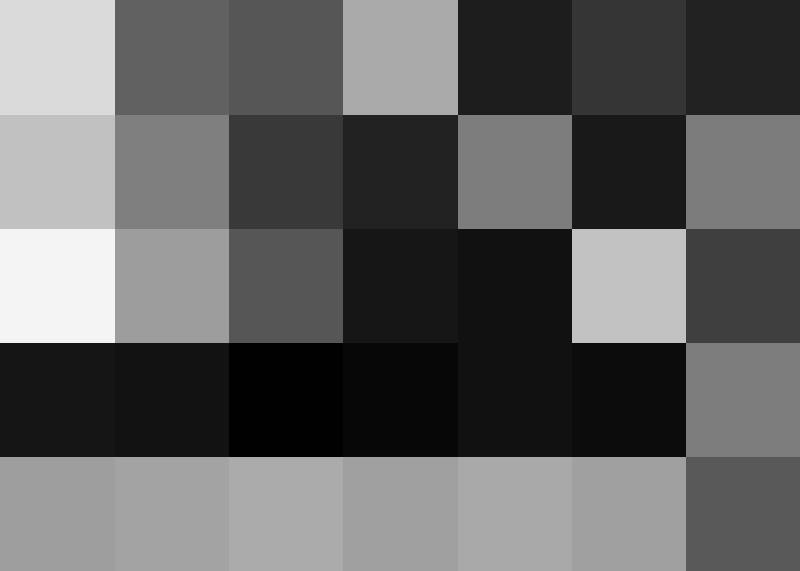

In [4]:
# Show the array as an inline data url in png-format
display.show_image(img_array)

### Output data
We know what the input looks like, let's figure out what output data we expect from our feature detector. 
To make the output portable, we'll ultimately store and transmit it in json format. It will be an array of objects.

In [5]:
# This is what the json data looks like. Conveniently it's also valid python code.
data =  [
  {
    "className": "keypoint one",
    "x": 0.305,
    "y": 0.255,
    "width": 0.291,
    "height": 0.392,
    "weight": 1.644
  },
  {
    "className": "keypoint two",
    "x": 0.273,
    "y": 0.222,
    "width": 0.086,
    "height": 0.116,
    "weight": 0.362
  }
]

Each feature is represented as a rectangle in a coordinate system where (0, 0) is the upper left corner of the image and (1, 1) is the lower right corner of the image. This is convenient since we are going to use this data to render html and svg graphics.

`className` is a string that will be used as a css class for the feature, so we can distinguish various types of features.

`x` and `y` are the coordinates of the upper left corner of the feature

`weight` is a quantity representing the relative importance or saliency of a given feature.

To visualize these feature, we'll use reactjs and node to create a svg and html widget. 

In [6]:
from utils.reactjs import render  
from utils.cropengine import Feature
# Renders the widget with react, redux and node.js
features = [Feature.deserialize(d) for d in data]
render('./monkey-race.jpg', features)

The `Feature` class is not very complicated, so I will not go through the source code in detail. 

In [7]:
f1, f2 = features
f1

Feature(top=0.255, right=0.596, className='keypoint one', weight=1.644, left=0.305, bottom=0.647)

In [14]:
f1.__class__.__bases__  # Feature is a subclass of Box

(utils.boundingbox.Box,)

In [9]:
# Adding two features together will give us a new Box that contains both features.
f1 + f2

Box(top=0.222, right=0.596, bottom=0.647, left=0.273)

In [10]:
# The __and__ operator will return the intersection of the two features
f1 & f2

Box(top=0.255, right=0.359, bottom=0.338, left=0.305)

In [11]:
# Multiplication will change the size and weight of the Feature
# but the center point and className will not change.
f1 * 0.5 

Feature(top=0.353, right=0.52325, className='keypoint one', weight=0.822, left=0.37775000000000003, bottom=0.549)

* json output
* react widget
* discussion:
    * How can I use this?

## 4: Feature detector
* What is ORB?
* link to documentation
* code
* output
* discussion

## 5: Face detection
* What are Haas-cascades?
* code
* output
* discussion

## 6: Combined feature detector
* explanation
* code 
* output
* discussion

In [12]:
from utils import reactjs
reactjs.css()

## 7: Summary
* it's easy!
* links
    * OpenCV guy
    * documentation
    * sorl-thumbnail
* My own stuff
    * Algorithm
    * React component

In [13]:
from utils import cropengine
import json
detector = cropengine.KeypointDetector(n=5)
ff = detector.find_features('./monkey-race.jpg')
data = json.dumps([f.serialize() for f in ff], indent=2)
print(data)
display.croppify_all(detector, ['./monkey-race.jpg'])

[
  {
    "className": "ORB keypoint",
    "x": 0.495,
    "y": 0.235,
    "width": 0.291,
    "height": 0.392,
    "weight": 1.644
  },
  {
    "className": "ORB keypoint",
    "x": 0.504,
    "y": 0.379,
    "width": 0.194,
    "height": 0.262,
    "weight": 1.267
  },
  {
    "className": "ORB keypoint",
    "x": 0.478,
    "y": 0.427,
    "width": 0.129,
    "height": 0.174,
    "weight": 0.789
  },
  {
    "className": "ORB keypoint",
    "x": 0.444,
    "y": 0.186,
    "width": 0.086,
    "height": 0.116,
    "weight": 0.385
  },
  {
    "className": "ORB keypoint",
    "x": 0.573,
    "y": 0.442,
    "width": 0.086,
    "height": 0.116,
    "weight": 0.362
  }
]
